# Designing and using Simulators

[Simulator objects](https://imagine-code.readthedocs.io/en/latest/components.html#simulators)
are responsible for converting into 
[Observables](https://imagine-code.readthedocs.io/en/latest/components.html#measurements-simulations-and-covariances)
the physical quantities computed/stored by the 
[Field](https://imagine-code.readthedocs.io/en/latest/components.html#fields) objects. 

Here we exemplify how to construct a Simulator for the case of computing the Faraday rotation measures on due an extended intervening galaxy with many background radio sources.  For simplicity, the simulator assumes that the observed galaxy is either fully 'face-on' or 'edge-on'.

In [1]:
import imagine as img
import numpy as np
import astropy.units as u

class ExtragalacticBacklitFaradaySimulator(img.Simulator):
    """ 
    Example simulator to illustrate
    """
    
    # Class attributes
    SIMULATED_QUANTITIES = ['testRM']
    REQUIRED_FIELD_TYPES = ['magnetic_field', 'thermal_electron_density']
    ALLOWED_GRID_TYPES = ['cartesian', 'NonUniformCartesian']

    def __init__(self, measurements, galaxy_distance, galaxy_latitude, 
                 galaxy_longitude, orientation='edge-on', 
                 beam_size=2*u.kpc):
        # Send the Measurements to the parent class
        super().__init__(measurements)
        # Stores class-specific attributes
        self.galaxy_distance = galaxy_distance
        self.galaxy_lat = u.Quantity(galaxy_latitude, u.deg)
        self.galaxy_lon = u.Quantity(galaxy_longitude, u.deg)
        self.orientation = orientation
        self.beam = beam_size
    
    def simulate(self, key, coords_dict, realization_id, output_units):
        # Accesses fields and grid 
        B = self.fields['magnetic_field']
        ne = self.fields['thermal_electron_density']
        grid = self.grid
        # Note: the contents of self.fields correspond the present (single) 
        # realization, the realization_id variable is available if extra
        # control is needed
        
        if self.orientation == 'edge-on':
            integration_axis = 0
            Bpara = B[:,:,:,0] # i.e. Bpara = Bx
            depths = grid.x[:,0,0]
        elif self.orientation == 'face-on':
            integration_axis = 2
            Bpara = B[:,:,:,2] # i.e. Bpara = Bz
            depths = grid.z[0,0,:]
        else:
            raise ValueError('Orientation must be either face-on or edge-on')
        
        # Computes dl in parsecs
        ddepth = (np.abs(depths[1]-depths[0])).to(u.pc)
        
        # Convert the coordinates from angles to 
        # positions on one face of the grid
        lat, lon = coords_dict['lat'], coords_dict['lon']
        
        # Creates the outputarray
        results = np.empty(lat.size)*u.rad/u.m**2
        
        # Computes RMs for the entire box
        RM_array = 0.812*u.rad/u.m**2 *((ne/(u.cm**-3)) *
                                        (Bpara/(u.microgauss)) * 
                                        ddepth/u.pc).sum(axis=integration_axis)
        # NB in an *production* version this would be computed only
        #    for the relevant coordinates/sightlines instead of aroungthe 
        #    the whole grid, to save memory and CPU time
        
        # Prepares the results
        if self.orientation=='edge-on':
            # Gets y and z for a slice of the grid
            face_y = grid.y[0,:,:]
            face_z = grid.z[0,:,:]
            # Converts the tabulated galactic coords into y and z
            y_targets = (lat-self.galaxy_lat)*self.galaxy_distance
            z_targets = (lon-self.galaxy_lon)*self.galaxy_distance
            # Adjusts and removes units
            y_targets = y_targets.to(u.kpc, u.dimensionless_angles())
            z_targets = z_targets.to(u.kpc, u.dimensionless_angles())
            # Selects the relevant values from the RM array
            # (averaging neighbouring pixes within the same "beam")
            for i, (y, z) in enumerate(zip(y_targets, z_targets)):
                mask = (face_y-y)**2+(face_z-z)**2 < (self.beam)**2
                beam = RM_array[mask]
                results[i]=np.mean(beam)
        elif self.orientation=='face-on':
            # Gets x and y for a slice of the grid
            face_x = grid.x[:,:,0]
            face_y = grid.y[:,:,0]
            # Converts the tabulated galactic coords into x and y
            x_targets = (lat-self.galaxy_lat)*self.galaxy_distance
            y_targets = (lon-self.galaxy_lon)*self.galaxy_distance
            # Adjusts and removes units
            x_targets = x_targets.to(u.kpc, u.dimensionless_angles())
            y_targets = y_targets.to(u.kpc, u.dimensionless_angles())
            # Selects the relevant values from the RM array
            # (averaging neighbouring pixes within the same "beam"
            for i, (x, y) in enumerate(zip(x_targets, y_targets)):
                mask = (face_x-x)**2+(face_y-y)**2 < (self.beam)**2
                beam = RM_array[mask]
                results[i]=np.mean(beam)
        return results

Thus, when designing a Simulator, one basically overrides the `simulate()` method, substituting it by some calculation which
maps the various fields to some observable quantity. The available fields can be accessed through the attribute self.fields, 
which is a dictionary containing the field types as keys. The details of the observable can be found through the keyword 
arguments: key (which is the key of Measurements dictionary), coords_dict (available for tabular datasets only) 
and output_units (note that the value returned does not need to be exactly in the output_units, but must be convertible to them).

To see this working, let us create some fake sky coordinates over a rectangle around a galaxy
that is located at galactic coordinates $(b,\,l)=(30^{\rm o},\,30^{\rm o})$

In [2]:
fake_sky_position_x, fake_sky_position_y = np.meshgrid(np.linspace(-4,4,70)*u.kpc,
                                                       np.linspace(-4,4,70)*u.kpc)
gal_lat = 30*u.deg; gal_lon = 30*u.deg
fake_lat = gal_lat+np.arctan2(fake_sky_position_x,1*u.Mpc)
fake_lon =  gal_lon+np.arctan2(fake_sky_position_y,1*u.Mpc)

fake_data = {'RM': np.random.random_sample(fake_lat.size),
             'err': np.random.random_sample(fake_lat.size),
             'lat': fake_lat.ravel(),
             'lon': fake_lon.ravel()}

From this one can construct the dataset and append it to the `Measurements` object

In [3]:
fake_dset = img.observables.TabularDataset(fake_data, name='testRM', units= u.rad/u.m/u.m,
                           data_column='RM', error_column='err', 
                           lat_column='lat', lon_column='lon')
# Initializes Measurements and Covariances objects
mea = img.Measurements()
cov = img.Covariances()
# Appends the fake tabular data
mea.append(dataset=fake_dset)
cov.append(dataset=fake_dset)
mea.keys()

dict_keys([('testRM', 'nan', 'tab', 'nan')])

The measurements object will provide enough information to setup/instantiate the simulator

In [4]:
edgeon_RMsimulator = ExtragalacticBacklitFaradaySimulator(mea, galaxy_distance=1*u.Mpc,
                                           galaxy_latitude=gal_lat,
                                           galaxy_longitude=gal_lon,
                                           beam_size=0.700*u.kpc,
                                           orientation='edge-on')
faceon_RMsimulator = ExtragalacticBacklitFaradaySimulator(mea, galaxy_distance=1*u.Mpc,
                                           galaxy_latitude=gal_lat,
                                           galaxy_longitude=gal_lon,
                                           beam_size=0.7*u.kpc,
                                           orientation='face-on')

To test it, we will generate a dense grid and evaluate a magnetic field and electron density on top of it

In [5]:
from imagine.fields.basic_fields import ConstantMagneticField, ExponentialThermalElectrons

dense_grid = img.UniformGrid(box=[[-15, 15]*u.kpc,
                                  [-15, 15]*u.kpc,
                                  [-15, 15]*u.kpc],
                             resolution = [30,30,30])
B = ConstantMagneticField(grid=dense_grid, ensemble_size=1,
                          parameters={'Bx': 0.5*u.microgauss,
                                      'By': 0.5*u.microgauss,
                                      'Bz': 0.5*u.microgauss})
ne_disk = ExponentialThermalElectrons(grid=dense_grid, ensemble_size=1,
                                 parameters={'central_density': 0.5*u.cm**-3, 
                                             'scale_radius': 3.3*u.kpc, 
                                             'scale_height': 0.5*u.kpc})

Now we can call the simulator, which returns a `Simulation` object

In [6]:
edgeon_sim = edgeon_RMsimulator([B,ne_disk])
faceon_sim = faceon_RMsimulator([B,ne_disk])
print('faceon_sim:',faceon_sim)
print('faceon_sim keys:',list(faceon_sim.keys()))

faceon_sim: <imagine.observables.observable_dict.Simulations object at 0x7f446c17f510>
faceon_sim keys: [('testRM', 'nan', 'tab', 'nan')]


In [7]:
faceon_sim[('testRM', 'nan', 'tab', 'nan')].data.shape

(1, 4900)

Using the fact that the original coordinates correspondended to a rectangle in the sky, we can visualize the results

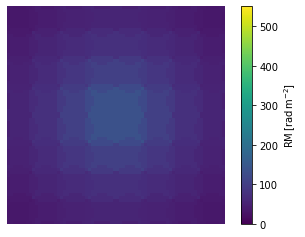

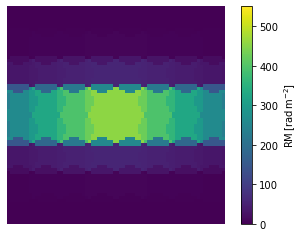

In [8]:
import matplotlib.pyplot as plt

i = 0
key = tuple(faceon_sim.keys())[0]
d = faceon_sim[key].data[i]
# Using the fact that the coordinates correspond to a rectangle
im = d.reshape(int(np.sqrt(d.size)),int(np.sqrt(d.size)))
plt.imshow(im, vmin=0, vmax=550); plt.axis('off')
plt.colorbar(label=r'$\rm RM\,[ rad\,m^{-2}]$')

plt.figure()
key = tuple(edgeon_sim.keys())[0]
d = edgeon_sim[key].data[i]
# Using the fact that the coordinates correspond to a rectangle
im = d.reshape(int(np.sqrt(d.size)),int(np.sqrt(d.size)))
plt.imshow(im, vmin=0, vmax=550); plt.axis('off')
plt.colorbar(label=r'$\rm RM\,[ rad\,m^{-2}]$');

Simulators are able to handle *multiple fields of the same type* by summing up their data. This is particularly convenient if a physical quantity is described by a both a deterministic part and random fluctuations.

We will illustrate this with another artificial example, reusing the `RandomThermalElectrons` field discussed before. We will also illustrate the usage of ensembles (note: for non-stochastic fields the ensemble size has to be kept the same to ensure consistency, but internally they will be evaluated only once).

In [9]:
from imagine.fields import RandomThermalElectrons

dense_grid = img.UniformGrid(box=[[-15, 15]*u.kpc,
                                  [-15, 15]*u.kpc,
                                  [-15, 15]*u.kpc],
                             resolution = [30,30,30])
B = ConstantMagneticField(grid=dense_grid, ensemble_size=3,
                          parameters={'Bx': 0.5*u.microgauss,
                                      'By': 0.5*u.microgauss,
                                      'Bz': 0.5*u.microgauss})
ne_disk = ExponentialThermalElectrons(grid=dense_grid, ensemble_size=3,
                                 parameters={'central_density': 0.5*u.cm**-3, 
                                             'scale_radius': 3.3*u.kpc, 
                                             'scale_height': 0.5*u.kpc})
ne_rnd = RandomThermalElectrons(grid=dense_grid, ensemble_size=3,
                                parameters={'mean': 0.005*u.cm**-3, 
                                            'std': 0.01*u.cm**-3,
                                            'min_ne' : 0*u.cm**-3})

The extra field can be included in the simulator using

In [10]:
edgeon_sim = edgeon_RMsimulator([B,ne_disk,ne_rnd])
faceon_sim = faceon_RMsimulator([B,ne_disk,ne_rnd])

Let us now plot, as before, the simulated observables for each realisation

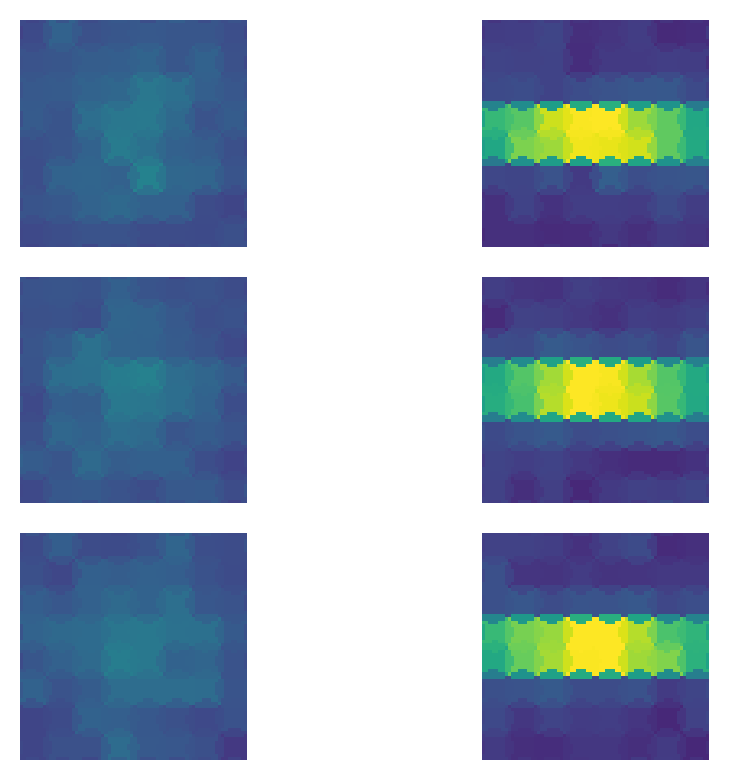

In [11]:
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, dpi=200)

for i, ax in enumerate(axs):
    key = tuple(faceon_sim.keys())[0]
    d = faceon_sim[key].data[i]
    ax[0].imshow(d.reshape(int(np.sqrt(d.size)),int(np.sqrt(d.size))),
           vmin=0, vmax=550)
    
    key = tuple(edgeon_sim.keys())[0]
    d = edgeon_sim[key].data[i]
    ax[1].imshow(d.reshape(int(np.sqrt(d.size)),int(np.sqrt(d.size))),
                 vmin=0, vmax=550)
    ax[1].axis('off'); ax[0].axis('off')
plt.tight_layout()